In [2]:
from fynesse import access, assess, address

from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tabulate import tabulate

In [3]:
from config import *

## Feature Construction

In [3]:
# load master dictionary for everything

master_dict = assess.eat_pickle(f'./data/pickle/master.pickle')

In [5]:
# choose your desired event combo

test_idx = 0

events = ['cache-misses', 'L1-dcache-loads', 'fp_arith_inst_retired.256b_packed_single', 'fp_arith_inst_retired.scalar_single']
n_bins = 32

X = address.make_features(master_dict, events, n_bins=n_bins, models=MODELS, n_samples=100*len(SEEDS))


## Dataset Splitting

In [6]:
# split based on random seed value

X, X_test_unseen = address.seed_split(X, seed_idx=test_idx, n_seeds=len(SEEDS), n_samples=100)

# feature scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X)
X = scaler.transform(X)
X_test_unseen = scaler.transform(X_test_unseen)

In [7]:
# add labels

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder().fit(MODELS)

y = list()
for model in MODELS:
    y += [model] * (100*(len(SEEDS)-1))
y = le.transform(y)

y_test_unseen = list()
for model in MODELS:
    y_test_unseen += [model] * 100
y_test_unseen = le.transform(y_test_unseen)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Tuning and Testing

## Utilities

In [9]:
from sklearn.model_selection import GridSearchCV

def print_grid_search_results(cv_results_):
    print(tabulate(np.column_stack([cv_results_['params'], cv_results_['mean_test_score'], cv_results_['rank_test_score']]), headers=['params', 'score', 'rank']))

In [28]:
def print_best_grid_search_results(cv_results_):
    rows = []

    for i in range(len(cv_results_['params'])):
        if cv_results_['rank_test_score'][i] == 1:
            rows.append([cv_results_['params'][i], cv_results_['mean_test_score'][i], cv_results_['rank_test_score'][i]])

    print(tabulate(rows, headers=['params', 'score', 'rank']))

In [11]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def evaluate(clf, X_test, y_test):
    accuracy = accuracy_score(y_test, clf.predict(X_test))
    f1 = f1_score(y_test, clf.predict(X_test), average='macro')
    precision = precision_score(y_test, clf.predict(X_test), average='macro')
    recall = recall_score(y_test, clf.predict(X_test), average='macro')

    print(f'Accuracy: {accuracy}')
    print(f'F1: {f1}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')

## $k$-NN

### Hyperparameter Tuning

In [26]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

params = {'n_neighbors': [1,3,5,10],
          'weights': ['uniform','distance'],
          'p': [1,2,3]}

clf = GridSearchCV(knn, params, cv=5)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 3, 5, 10], 'p': [1, 2, 3],
                         'weights': ['uniform', 'distance']})

In [29]:
print_best_grid_search_results(clf.cv_results_)

params                                                score    rank
--------------------------------------------------  -------  ------
{'n_neighbors': 10, 'p': 1, 'weights': 'uniform'}         1       1
{'n_neighbors': 10, 'p': 1, 'weights': 'distance'}        1       1


### Training

In [30]:
knn = KNeighborsClassifier(n_neighbors=10,
                           p=1,
                           weights='uniform')

knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10, p=1)

### Evaluation

In [31]:
evaluate(knn, X_test, y_test)

Accuracy: 1.0
F1: 1.0
Precision: 1.0
Recall: 1.0


In [32]:
evaluate(knn, X_test_unseen, y_test_unseen)

Accuracy: 1.0
F1: 1.0
Precision: 1.0
Recall: 1.0


## DT

### Hyperparameter Tuning

In [33]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()

params = {'criterion': ['gini','entropy','log_loss'],
          'splitter': ['best', 'random'],
          'random_state': [42]}

clf = GridSearchCV(dt, params, cv=5)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'random_state': [42], 'splitter': ['best', 'random']})

In [34]:
print_best_grid_search_results(clf.cv_results_)

params                                                               score    rank
-----------------------------------------------------------------  -------  ------
{'criterion': 'gini', 'random_state': 42, 'splitter': 'best'}            1       1
{'criterion': 'entropy', 'random_state': 42, 'splitter': 'best'}         1       1
{'criterion': 'log_loss', 'random_state': 42, 'splitter': 'best'}        1       1


### Training

In [35]:
dt = DecisionTreeClassifier(criterion='gini',
                            random_state=42,
                            splitter='best')

dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

### Evaluation

In [36]:
evaluate(dt, X_test, y_test)

Accuracy: 0.9933333333333333
F1: 0.9933326665999934
Precision: 0.9934640522875817
Recall: 0.9933333333333333


In [37]:
evaluate(dt, X_test_unseen, y_test_unseen)

Accuracy: 0.9933333333333333
F1: 0.9933333333333333
Precision: 0.9933333333333333
Recall: 0.9933333333333333


## RF

### Hyperparameter Tuning

In [38]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)

params = {'n_estimators': [1, 5, 10, 25, 50, 100, 250, 500, 1000],
          'criterion': ['gini','entropy','log_loss'],
          'random_state': [42]}

clf = GridSearchCV(rf, params, cv=5)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'n_estimators': [1, 5, 10, 25, 50, 100, 250, 500,
                                          1000],
                         'random_state': [42]})

In [39]:
print_best_grid_search_results(clf.cv_results_)

params                                                                 score    rank
-------------------------------------------------------------------  -------  ------
{'criterion': 'gini', 'n_estimators': 5, 'random_state': 42}               1       1
{'criterion': 'gini', 'n_estimators': 10, 'random_state': 42}              1       1
{'criterion': 'gini', 'n_estimators': 25, 'random_state': 42}              1       1
{'criterion': 'gini', 'n_estimators': 50, 'random_state': 42}              1       1
{'criterion': 'gini', 'n_estimators': 100, 'random_state': 42}             1       1
{'criterion': 'gini', 'n_estimators': 250, 'random_state': 42}             1       1
{'criterion': 'gini', 'n_estimators': 500, 'random_state': 42}             1       1
{'criterion': 'gini', 'n_estimators': 1000, 'random_state': 42}            1       1
{'criterion': 'entropy', 'n_estimators': 5, 'random_state': 42}            1       1
{'criterion': 'entropy', 'n_estimators': 10, 'random_state': 42} 

### Training

In [40]:
rf = RandomForestClassifier(criterion='gini',
                            n_estimators=5,
                            random_state=42)

rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=5, random_state=42)

### Evaluation

In [41]:
evaluate(rf, X_test, y_test)

Accuracy: 0.9966666666666667
F1: 0.9966665833312499
Precision: 0.9966996699669967
Recall: 0.9966666666666667


In [42]:
evaluate(rf, X_test_unseen, y_test_unseen)

Accuracy: 0.9966666666666667
F1: 0.9966665833312499
Precision: 0.9966996699669967
Recall: 0.9966666666666667


## MLP

### Hyperparameter Tuning

In [43]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier()

params = {'hidden_layer_sizes': [[i+1] for i in range(10)],
          'activation': ['identity', 'logistic', 'tanh', 'relu'],
          'solver': ['sgd', 'adam'],
          'learning_rate_init': [0.001, 0.005, 0.01],
          'max_iter': [1000, 2500, 5000],
          'momentum': [0.9, 0.99],
          'random_state': [42]}

clf = GridSearchCV(mlp, params, cv=5)
clf.fit(X_train, y_train)

/Users/kate/anaconda3/envs/diss/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kate/anaconda3/envs/diss/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kate/anaconda3/envs/diss/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kate/anaconda3/envs/diss/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.wa

GridSearchCV(cv=5, estimator=MLPClassifier(),
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'hidden_layer_sizes': [[1], [2], [3], [4], [5], [6],
                                                [7], [8], [9], [10]],
                         'learning_rate_init': [0.001, 0.005, 0.01],
                         'max_iter': [1000, 2500, 5000],
                         'momentum': [0.9, 0.99], 'random_state': [42],
                         'solver': ['sgd', 'adam']})

In [44]:
print_best_grid_search_results(clf.cv_results_)

params                                                                                                                                                            score    rank
-------------------------------------------------------------------------------------------------------------------------------------------------------------  --------  ------
{'activation': 'identity', 'hidden_layer_sizes': [1], 'learning_rate_init': 0.005, 'max_iter': 1000, 'momentum': 0.99, 'random_state': 42, 'solver': 'sgd'}    0.998889       1
{'activation': 'identity', 'hidden_layer_sizes': [1], 'learning_rate_init': 0.005, 'max_iter': 2500, 'momentum': 0.99, 'random_state': 42, 'solver': 'sgd'}    0.998889       1
{'activation': 'identity', 'hidden_layer_sizes': [1], 'learning_rate_init': 0.005, 'max_iter': 5000, 'momentum': 0.99, 'random_state': 42, 'solver': 'sgd'}    0.998889       1
{'activation': 'identity', 'hidden_layer_sizes': [1], 'learning_rate_init': 0.01, 'max_iter': 1000, 'momentum': 0.99, 'r

### Training

In [45]:
mlp = MLPClassifier(activation='identity',
                    hidden_layer_sizes=[3], 
                    learning_rate_init=0.01,
                    max_iter=2500, 
                    momentum=0.99,
                    random_state=42,
                    solver='sgd')

mlp.fit(X_train, y_train)

MLPClassifier(activation='identity', hidden_layer_sizes=[3],
              learning_rate_init=0.01, max_iter=2500, momentum=0.99,
              random_state=42, solver='sgd')

### Evaluation

In [46]:
evaluate(mlp, X_test, y_test)

Accuracy: 0.9966666666666667
F1: 0.9966665833312499
Precision: 0.9966996699669967
Recall: 0.9966666666666667


In [47]:
evaluate(mlp, X_test_unseen, y_test_unseen)

Accuracy: 0.9933333333333333
F1: 0.993349586214903
Precision: 0.9934640522875817
Recall: 0.9933333333333333


## SVM

### Hyperparameter Tuning

In [48]:
from sklearn.linear_model import SGDClassifier

svm = SGDClassifier()

params = {'loss': ['hinge'],
          'penalty': ['elasticnet'],
          'alpha': [0.0001, 0.001, 0.01, 0.1],
          'l1_ratio': [0, 0.25, 0.5, 0.75, 1],
          'random_state': [42]}

clf = GridSearchCV(svm, params, cv=5)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SGDClassifier(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1],
                         'l1_ratio': [0, 0.25, 0.5, 0.75, 1], 'loss': ['hinge'],
                         'penalty': ['elasticnet'], 'random_state': [42]})

In [49]:
print_best_grid_search_results(clf.cv_results_)

params                                                                                                score    rank
-------------------------------------------------------------------------------------------------  --------  ------
{'alpha': 0.0001, 'l1_ratio': 0, 'loss': 'hinge', 'penalty': 'elasticnet', 'random_state': 42}     0.998889       1
{'alpha': 0.0001, 'l1_ratio': 0.25, 'loss': 'hinge', 'penalty': 'elasticnet', 'random_state': 42}  0.998889       1
{'alpha': 0.0001, 'l1_ratio': 0.5, 'loss': 'hinge', 'penalty': 'elasticnet', 'random_state': 42}   0.998889       1
{'alpha': 0.001, 'l1_ratio': 0, 'loss': 'hinge', 'penalty': 'elasticnet', 'random_state': 42}      0.998889       1
{'alpha': 0.001, 'l1_ratio': 0.25, 'loss': 'hinge', 'penalty': 'elasticnet', 'random_state': 42}   0.998889       1
{'alpha': 0.001, 'l1_ratio': 0.5, 'loss': 'hinge', 'penalty': 'elasticnet', 'random_state': 42}    0.998889       1
{'alpha': 0.001, 'l1_ratio': 0.75, 'loss': 'hinge', 'penalty': 'elasticn

### Training

In [51]:
svm = SGDClassifier(loss='hinge',
                    random_state=42)

svm.fit(X_train, y_train)

SGDClassifier(random_state=42)

### Evaluation

In [52]:
evaluate(svm, X_test, y_test)

Accuracy: 1.0
F1: 1.0
Precision: 1.0
Recall: 1.0


In [53]:
evaluate(svm, X_test_unseen, y_test_unseen)

Accuracy: 0.9966666666666667
F1: 0.9966665833312499
Precision: 0.9966996699669967
Recall: 0.9966666666666667


# Actual Work

## Evaluation

In [54]:
def record_evaluation(memo, clf_name, seed, clf, X_test, y_test, X_test_unseen, y_test_unseen):
    accuracy = accuracy_score(y_test, clf.predict(X_test))
    f1 = f1_score(y_test, clf.predict(X_test), average='macro')
    precision = precision_score(y_test, clf.predict(X_test), average='macro')
    recall = recall_score(y_test, clf.predict(X_test), average='macro')

    accuracy_unseen = accuracy_score(y_test_unseen, clf.predict(X_test_unseen))
    f1_unseen = f1_score(y_test_unseen, clf.predict(X_test_unseen), average='macro')
    precision_unseen = precision_score(y_test_unseen, clf.predict(X_test_unseen), average='macro')
    recall_unseen = recall_score(y_test_unseen, clf.predict(X_test_unseen), average='macro')

    memo.append([clf_name, seed, accuracy, f1, precision, recall, accuracy_unseen, f1_unseen, precision_unseen, recall_unseen])

In [55]:
# feature parameters
featured_events = ['cache-misses', 'L1-dcache-loads', 'fp_arith_inst_retired.256b_packed_single', 'fp_arith_inst_retired.scalar_single']
n_bins = 32

memo = []

for test_idx in range(len(SEEDS)):
    X = address.make_features(master_dict, featured_events, n_bins=n_bins, models=MODELS, n_samples=100*len(SEEDS))

    # split based on random seed value
    X, X_test_unseen = address.seed_split(X, seed_idx=test_idx, n_seeds=len(SEEDS), n_samples=100)

    # feature scaling
    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)
    X_test_unseen = scaler.transform(X_test_unseen)

    # add labels
    le = LabelEncoder().fit(MODELS)

    y = list()
    for model in MODELS:
        y += [model] * (100*(len(SEEDS)-1))
    y = le.transform(y)

    y_test_unseen = list()
    for model in MODELS:
        y_test_unseen += [model] * 100
    y_test_unseen = le.transform(y_test_unseen)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

    # KNN
    knn = KNeighborsClassifier(n_neighbors=10,
                            p=1,
                            weights='uniform')

    knn.fit(X_train, y_train)
    record_evaluation(memo, 'KNN', SEEDS[test_idx], knn, X_test, y_test, X_test_unseen, y_test_unseen)

    # DT
    dt = DecisionTreeClassifier(criterion='gini',
                            random_state=42,
                            splitter='best')

    dt.fit(X_train, y_train)
    record_evaluation(memo, 'DT', SEEDS[test_idx], dt, X_test, y_test, X_test_unseen, y_test_unseen)

    # RF
    rf = RandomForestClassifier(criterion='gini',
                            n_estimators=5,
                            random_state=42)

    rf.fit(X_train, y_train)
    record_evaluation(memo, 'RF', SEEDS[test_idx], rf, X_test, y_test, X_test_unseen, y_test_unseen)

    # MLP
    mlp = MLPClassifier(activation='identity',
                    hidden_layer_sizes=[3], 
                    learning_rate_init=0.01,
                    max_iter=2500, 
                    momentum=0.99,
                    random_state=42,
                    solver='sgd')

    mlp.fit(X_train, y_train)
    record_evaluation(memo, 'MLP', SEEDS[test_idx], mlp, X_test, y_test, X_test_unseen, y_test_unseen)

    # SVM
    svm = SGDClassifier(loss='hinge',
                    random_state=42)

    svm.fit(X_train, y_train)
    record_evaluation(memo, 'SVM', SEEDS[test_idx], svm, X_test, y_test, X_test_unseen, y_test_unseen)

In [56]:
df = pd.DataFrame(memo, columns=['clf', 'seed', 'accuracy', 'f1', 'precision', 'recall', 'accuracy_unseen', 'f1_unseen', 'precision_unseen', 'recall_unseen'])
df.to_csv('./data/core_eval.csv', index=False)

### Extension

In [4]:
# load master dictionary for everything

master_dict_ext = assess.eat_pickle(f'./data/pickle/master_ext.pickle')

In [67]:
# feature parameters
featured_events = ['cache-misses', 'L1-dcache-loads', 'fp_arith_inst_retired.256b_packed_single', 'fp_arith_inst_retired.scalar_single']
n_bins = 32

memo = []

for test_idx in range(len(SEEDS)):
    X = address.make_features(master_dict_ext, featured_events, n_bins=n_bins, models=MODELS+MODELS_EXT, n_samples=100*len(SEEDS))

    # split based on random seed value
    X, X_test_unseen = address.seed_split(X, seed_idx=test_idx, n_seeds=len(SEEDS), n_samples=100)

    # feature scaling
    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)
    X_test_unseen = scaler.transform(X_test_unseen)

    # add labels
    le = LabelEncoder().fit(MODELS+MODELS_EXT)

    y = list()
    for model in MODELS+MODELS_EXT:
        y += [model] * (100*(len(SEEDS)-1))
    y = le.transform(y)

    y_test_unseen = list()
    for model in MODELS+MODELS_EXT:
        y_test_unseen += [model] * 100
    y_test_unseen = le.transform(y_test_unseen)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

    # KNN
    knn = KNeighborsClassifier(n_neighbors=10,
                            p=1,
                            weights='uniform')

    knn.fit(X_train, y_train)
    record_evaluation(memo, 'KNN', SEEDS[test_idx], knn, X_test, y_test, X_test_unseen, y_test_unseen)

    # DT
    dt = DecisionTreeClassifier(criterion='gini',
                            random_state=42,
                            splitter='best')

    dt.fit(X_train, y_train)
    record_evaluation(memo, 'DT', SEEDS[test_idx], dt, X_test, y_test, X_test_unseen, y_test_unseen)

    # RF
    rf = RandomForestClassifier(criterion='gini',
                            n_estimators=5,
                            random_state=42)

    rf.fit(X_train, y_train)
    record_evaluation(memo, 'RF', SEEDS[test_idx], rf, X_test, y_test, X_test_unseen, y_test_unseen)

    # MLP
    mlp = MLPClassifier(activation='identity',
                    hidden_layer_sizes=[3], 
                    learning_rate_init=0.01,
                    max_iter=2500, 
                    momentum=0.99,
                    random_state=42,
                    solver='sgd')

    mlp.fit(X_train, y_train)
    record_evaluation(memo, 'MLP', SEEDS[test_idx], mlp, X_test, y_test, X_test_unseen, y_test_unseen)

    # SVM
    svm = SGDClassifier(loss='hinge',
                    random_state=42)

    svm.fit(X_train, y_train)
    record_evaluation(memo, 'SVM', SEEDS[test_idx], svm, X_test, y_test, X_test_unseen, y_test_unseen)

In [68]:
df = pd.DataFrame(memo, columns=['clf', 'seed', 'accuracy', 'f1', 'precision', 'recall', 'accuracy_unseen', 'f1_unseen', 'precision_unseen', 'recall_unseen'])
df.to_csv('./data/ext_eval.csv', index=False)

## Few-shot Learning

In [62]:
def record_evaluation_fs(memo, clf_name, train_size, seed, clf, X_test, y_test, X_test_unseen, y_test_unseen):
    accuracy = accuracy_score(y_test, clf.predict(X_test))
    f1 = f1_score(y_test, clf.predict(X_test), average='macro')
    precision = precision_score(y_test, clf.predict(X_test), average='macro')
    recall = recall_score(y_test, clf.predict(X_test), average='macro')

    accuracy_unseen = accuracy_score(y_test_unseen, clf.predict(X_test_unseen))
    f1_unseen = f1_score(y_test_unseen, clf.predict(X_test_unseen), average='macro')
    precision_unseen = precision_score(y_test_unseen, clf.predict(X_test_unseen), average='macro')
    recall_unseen = recall_score(y_test_unseen, clf.predict(X_test_unseen), average='macro')

    memo.append([clf_name, train_size, seed, accuracy, f1, precision, recall, accuracy_unseen, f1_unseen, precision_unseen, recall_unseen])

In [63]:
# feature parameters
featured_events = ['cache-misses', 'L1-dcache-loads', 'fp_arith_inst_retired.256b_packed_single', 'fp_arith_inst_retired.scalar_single']
n_bins = 32
models = MODELS

memo = []

for train_size in [1, 4, 16, 64, 128]:

    for test_idx in range(len(SEEDS)):
        X = address.make_features(master_dict, featured_events, n_bins=n_bins, models=models, n_samples=100*len(SEEDS))

        # split based on random seed value
        X, X_test_unseen = address.seed_split(X, seed_idx=test_idx, n_seeds=len(SEEDS), n_samples=100)

        # feature scaling
        scaler = StandardScaler().fit(X)
        X = scaler.transform(X)
        X_test_unseen = scaler.transform(X_test_unseen)

        # add labels
        le = LabelEncoder().fit(models)

        y = list()
        for model in models:
            y += [model] * (100*(len(SEEDS)-1))
        y = le.transform(y)

        y_test_unseen = list()
        for model in models:
            y_test_unseen += [model] * 100
        y_test_unseen = le.transform(y_test_unseen)

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=3*train_size/len(X), random_state=42, stratify=y)

        # KNN
        knn = KNeighborsClassifier(n_neighbors=10 if train_size > 10 else train_size,
                                p=1,
                                weights='uniform')

        knn.fit(X_train, y_train)
        record_evaluation_fs(memo, 'KNN', train_size, SEEDS[test_idx], knn, X_test, y_test, X_test_unseen, y_test_unseen)

        # DT
        dt = DecisionTreeClassifier(criterion='gini',
                                random_state=42,
                                splitter='best')

        dt.fit(X_train, y_train)
        record_evaluation_fs(memo, 'DT', train_size, SEEDS[test_idx], dt, X_test, y_test, X_test_unseen, y_test_unseen)

        # RF
        rf = RandomForestClassifier(criterion='gini',
                                n_estimators=5,
                                random_state=42)

        rf.fit(X_train, y_train)
        record_evaluation_fs(memo, 'RF', train_size, SEEDS[test_idx], rf, X_test, y_test, X_test_unseen, y_test_unseen)

        # MLP
        mlp = MLPClassifier(activation='identity',
                        hidden_layer_sizes=[3], 
                        learning_rate_init=0.01,
                        max_iter=2500, 
                        momentum=0.99,
                        random_state=42,
                        solver='sgd')

        mlp.fit(X_train, y_train)
        record_evaluation_fs(memo, 'MLP', train_size, SEEDS[test_idx], mlp, X_test, y_test, X_test_unseen, y_test_unseen)

        # SVM
        svm = SGDClassifier(loss='hinge',
                    random_state=42)

        svm.fit(X_train, y_train)
        record_evaluation_fs(memo, 'SVM', train_size, SEEDS[test_idx], svm, X_test, y_test, X_test_unseen, y_test_unseen)


/Users/kate/anaconda3/envs/diss/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kate/anaconda3/envs/diss/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kate/anaconda3/envs/diss/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [64]:
df = pd.DataFrame(memo, columns=['clf', 'train_size', 'seed', 'accuracy', 'f1', 'precision', 'recall', 'accuracy_unseen', 'f1_unseen', 'precision_unseen', 'recall_unseen'])
df.to_csv('./data/fs_eval.csv', index=False)

### Extension

In [65]:
# feature parameters
featured_events = ['cache-misses', 'L1-dcache-loads', 'fp_arith_inst_retired.256b_packed_single', 'fp_arith_inst_retired.scalar_single']
n_bins = 32
models = MODELS + MODELS_EXT

memo = []

for train_size in [1, 4, 16, 64, 128]:

    for test_idx in range(len(SEEDS)):
        X = address.make_features(master_dict_ext, featured_events, n_bins=n_bins, models=models, n_samples=100*len(SEEDS))

        # split based on random seed value
        X, X_test_unseen = address.seed_split(X, seed_idx=test_idx, n_seeds=len(SEEDS), n_samples=100)

        # feature scaling
        scaler = StandardScaler().fit(X)
        X = scaler.transform(X)
        X_test_unseen = scaler.transform(X_test_unseen)

        # add labels
        le = LabelEncoder().fit(models)

        y = list()
        for model in models:
            y += [model] * (100*(len(SEEDS)-1))
        y = le.transform(y)

        y_test_unseen = list()
        for model in models:
            y_test_unseen += [model] * 100
        y_test_unseen = le.transform(y_test_unseen)

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=len(models)*train_size/len(X), random_state=42, stratify=y)

        # KNN
        knn = KNeighborsClassifier(n_neighbors=10 if train_size > 10 else train_size,
                                p=1,
                                weights='uniform')

        knn.fit(X_train, y_train)
        record_evaluation_fs(memo, 'KNN', train_size, SEEDS[test_idx], knn, X_test, y_test, X_test_unseen, y_test_unseen)

        # DT
        dt = DecisionTreeClassifier(criterion='gini',
                                random_state=42,
                                splitter='best')

        dt.fit(X_train, y_train)
        record_evaluation_fs(memo, 'DT', train_size, SEEDS[test_idx], dt, X_test, y_test, X_test_unseen, y_test_unseen)

        # RF
        rf = RandomForestClassifier(criterion='gini',
                                n_estimators=5,
                                random_state=42)

        rf.fit(X_train, y_train)
        record_evaluation_fs(memo, 'RF', train_size, SEEDS[test_idx], rf, X_test, y_test, X_test_unseen, y_test_unseen)

        # MLP
        mlp = MLPClassifier(activation='identity',
                        hidden_layer_sizes=[3], 
                        learning_rate_init=0.01,
                        max_iter=2500, 
                        momentum=0.99,
                        random_state=42,
                        solver='sgd')

        mlp.fit(X_train, y_train)
        record_evaluation_fs(memo, 'MLP', train_size, SEEDS[test_idx], mlp, X_test, y_test, X_test_unseen, y_test_unseen)

        # SVM
        svm = SGDClassifier(loss='hinge',
                    random_state=42)

        svm.fit(X_train, y_train)
        record_evaluation_fs(memo, 'SVM', train_size, SEEDS[test_idx], svm, X_test, y_test, X_test_unseen, y_test_unseen)


/Users/kate/anaconda3/envs/diss/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kate/anaconda3/envs/diss/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kate/anaconda3/envs/diss/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [66]:
df = pd.DataFrame(memo, columns=['clf', 'train_size', 'seed', 'accuracy', 'f1', 'precision', 'recall', 'accuracy_unseen', 'f1_unseen', 'precision_unseen', 'recall_unseen'])
df.to_csv('./data/fs_ext_eval.csv', index=False)

## Feature Visualization

In [27]:
%matplotlib widget

In [4]:
# load master dictionary for everything

master_dict_ext = assess.eat_pickle(f'./data/pickle/master_ext.pickle')

### PCA

/var/folders/2s/wb3r0td11qs8d5h0krwymn400000gn/T/ipykernel_22142/1773248961.py:32: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


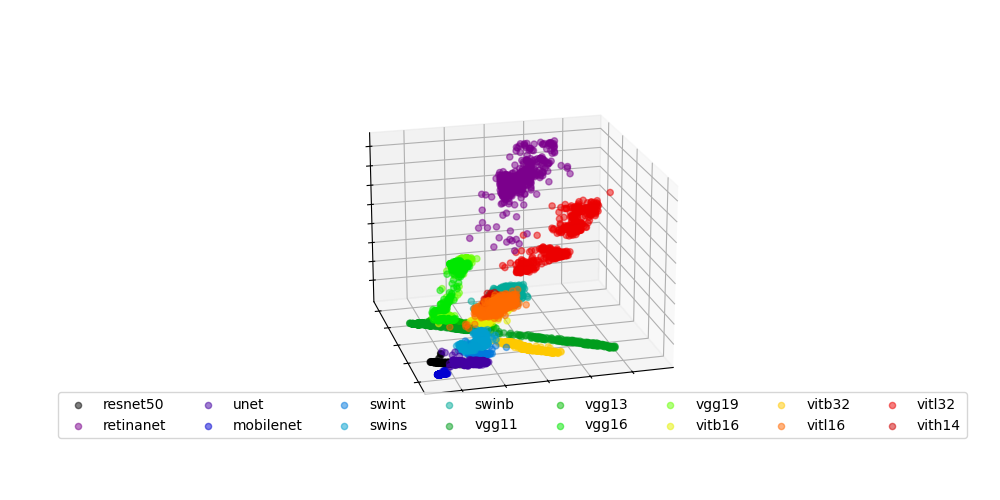

In [40]:
from sklearn.decomposition import PCA

models = MODELS + MODELS_EXT

events = ['cache-misses', 'L1-dcache-loads', 'fp_arith_inst_retired.256b_packed_single', 'fp_arith_inst_retired.scalar_single']
n_bins = 32

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = address.make_features(master_dict_ext, events, n_bins=n_bins, models=models, n_samples=100*len(SEEDS))
X = scaler.fit_transform(X)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection="3d", elev=20, azim=-105)

pca = PCA(n_components=3)
pca.fit(X)
X_pca = pca.transform(X)

cmap = plt.colormaps.get_cmap('nipy_spectral')

for i, model in enumerate(models):
    ax.scatter(X[i*500:(i+1)*500, 0], X[i*500:(i+1)*500, 1], X[i*500:(i+1)*500, 2], color=cmap(i/len(models)), label=model, alpha=0.5)

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

ax.legend(loc='lower center', ncols=8)

plt.tight_layout()
plt.savefig('./figures/features/pca.png')
plt.show()

### Cool Stuff

In [18]:
MODELS[2]

'unet'

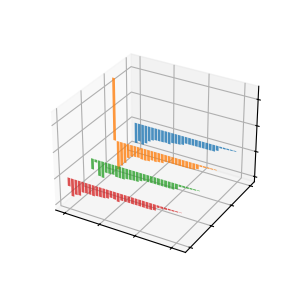

In [44]:
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(projection='3d')

colors = ['r', 'g', 'b', 'y']
yticks = [3, 2, 1, 0]

for i, (c, k) in enumerate(zip(colors, yticks)):
    # Generate the random data for the y=k 'layer'.
    timeseries = X[1001][i*32:(i+1)*32]
    

    # You can provide either a single color or an array with the same length as
    # xs and ys. To demonstrate this, we color the first bar of each set cyan.
    cs = [c] * len(timeseries)
    # cs[0] = 'c'

    # Plot the bar graph given by xs and ys on the plane y=k with 80% opacity.
    # ax.bar(np.arange(32), timeseries, zs=k, zdir='y', color=cs, alpha=0.8)
    ax.bar(np.arange(32), timeseries, zs=k, zdir='y', alpha=0.8)

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

plt.savefig('./figures/features/timeseries_unet.png')
plt.show()